In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers 
import scipy.stats as stats
import os 
import h5py
import sys
import re
%matplotlib inline 

In [2]:
model_name = "Weight_lep_pt"

In [3]:
# Throw away lepton mass 

# os.chdir('./../../../../../data/hongtao')
be = h5py.File('./../../../../../data/hongtao/variables_tt_re.h5','r')
bmu = h5py.File('./../../../../../data/hongtao/variables_tt_rmu.h5','r')
be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re1.h5','r')
print(be.keys())
print('')
print(be1.keys())
dataset = be1

<KeysViewHDF5 ['j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue']>

<KeysViewHDF5 ['bh_eta', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt'

In [4]:
input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
output_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi', 'wl_eta', 'wl_phi', 'wl_pt']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi', 'wl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'lep_eta', 'th_eta', 'tl_eta', 'wl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','lep_pt','th_pt', 'tl_pt', 'wl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r']

output_length = len(output_keys)
input_length = len(input_keys)
crop0 =  4000000

In [5]:
# plt.figure(figsize=(8,8*output_length))
# for i in range(0, output_length):
#     plt.subplot(output_length, 1, i+1)
#     plt.hist(dataset.get(output_keys[i]), 20, histtype='step')
#     plt.xlabel(output_keys[i])
#     plt.ylabel('Frequency')

In [6]:
lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
def phi_transform(arr, max0, mean):
    arr = (arr-mean)
    arr = arr/max0/1.01/2+0.5
    z = stats.norm.ppf(arr)/2.5
    return z 

def invphi_transform(z, max0, mean):
    arr = stats.norm.cdf(2.5*z)
    arr = (arr-0.5)*max0*1.01*2+mean
    return arr 

def jet_existence_dict():
    dic = {}
    for key in phi_keys:
        variable = key.split('_')[0]
        if bool(re.match('^j[0-9]+$', variable)): # If the variable is a jet
            v = np.array(dataset.get(variable + '_pt'))[0:crop0]
            dic[key] = (v>1)*1
        else:
            dic[key] = np.ones(crop0, dtype=int)
    return dic
        
def phi1_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    x = w - 2*np.pi*(w>np.pi)
    y = x - (1-exist)*np.pi*1.1
    y = y-mean
    z = y/max0
    return z

def invphi1_transform(z, max0, mean, exist):
    y = z*max0+mean
    x = y+(1-exist)*np.pi*1.1
    w = x + 2*np.pi*(x<0)
    arr = (w + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def phi2_transform(arr, max0, mean, exist):
    w = (arr - lep_phi*exist) % (2*np.pi)
    # x = w - 2*np.pi*(w>np.pi)
    y = w - (1-exist)*0.2
    z = y/(np.pi)
    return z

def invphi2_transform(z, max0, mean, exist):
    y = z*np.pi
    x = y+(1-exist)*0.2
    # w = x + 2*np.pi*(x<0)
    arr = (x + lep_phi*exist) % (2*np.pi)
    arr = arr - 2*np.pi*(arr > np.pi)
    return arr 


def pt_transform(arr, max0, mean):
    return arr/max0

def invpt_transform(z, max0, mean):
    return z*max0

def meanmax_transform(arr, max0, mean):
    arr = arr-mean
    z = arr/max0
    return z

def invmeanmax_transform(z, max0, mean):
    return z*max0+mean

def get_maxmean_dict(): 
    to_get = [pt_keys, eta_keys, m_keys, DL1r_keys]
    keys = ['pt', 'eta', 'm','DL1r']
    maxmean= {} 
    
    for i in range(4):
        dset = to_get[i]
        for x in dset:
            arr = []
            arr.append(np.array(dataset.get(x))[0:crop0])
        arr = np.stack(arr,axis=1)
        maxmean[keys[i]] = (np.max(np.abs(arr)), np.mean(arr))
    
    maxmean['phi'] = (np.pi, 0)
    maxmean['met'] = (np.max(np.abs(dataset.get('met_met'))), np.mean(dataset.get('met_met')))
    return maxmean 
    
def scale_arrays(keys, maxmean_dict):
    exist_dict = jet_existence_dict()
    lep_phi = np.array(dataset.get('lep_phi'))[0:crop0]
    
    arrays = []
    for key in keys:
        var = np.array(dataset.get(key))[0:crop0]
        if key in phi_keys:
            max0, mean = maxmean_dict['phi']
            exist = exist_dict[key]
            if key == 'tl_phi' or key == 'wl_phi':
                z = phi1_transform(var, max0, mean, exist) 
            else:
                z = phi2_transform(var, max0, mean, exist)
        elif key in pt_keys:
            max0, mean = maxmean_dict['pt']
            z = pt_transform(var, max0, mean)
        elif key in m_keys:
            max0, mean = maxmean_dict['m']
            z = pt_transform(var, max0, mean)
        else:
            max0, mean = maxmean_dict[key.split('_')[1]]
            z = meanmax_transform(var, max0, mean)
        arrays.append(z)
    arrays = np.stack(arrays, axis=1)
    return arrays

def invscale_arrays(keys, arrays, maxmean_dict):
    exist_dict = jet_existence_dict()

    total = []
    for i in range(arrays.shape[1]):
        z=arrays[:,i]
        full_key = keys[i]
        key = keys[i].split('_')[1]
        if key == 'pt':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        elif key=='phi':
            max0, mean = maxmean_dict[key]
            exist = exist_dict[full_key]
            if full_key == 'tl_phi' or full_key == 'wl_phi':
                total.append(invphi1_transform(z, max0, mean, exist))
            else:
                total.append(invphi2_transform(z, max0, mean, exist))
        elif key=='m':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        else:
            max0, mean = maxmean_dict[key]
            total.append(invmeanmax_transform(z, max0, mean))
            
    return np.stack(total,axis=1) 

In [7]:
# Convert into numpy arrays and mean normalize

maxmean = get_maxmean_dict()
total_input = scale_arrays(input_keys, maxmean)
total_input0 = total_input
total_output = scale_arrays(output_keys, maxmean)
total_output0 = total_output
out_scaled = invscale_arrays(output_keys, total_output, maxmean)

# No weighting in this version

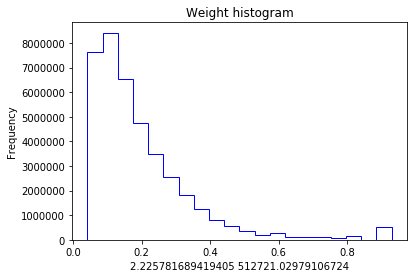

(4000000,)


In [8]:
# Reweight

def get_reweight1():
    key = 'lep_pt'
    i = input_keys.index(key)
    base = total_input[:,i]
    weight = (1 + base)**20
    return base, weight 
    
    
def get_reweight2():
    var = dataset.get('lep_pt')[0:crop0]
    max0 = np.max(var)
    bin_edges = np.linspace(0, max0, num=30, endpoint=True)
    bin_edges[-1] = np.inf
    hist0, _ = np.histogram(var,bin_edges, density=False)
    hist1 = (hist0==0)*1 + hist0
    

    pt_bin = np.digitize(var, bin_edges)-1
    weights = 1/hist1
    zweights = weights/np.min(weights)

    tr_weights = weights[pt_bin]
    return var, tr_weights, bin_edges
    
    
lep_pt, weight = get_reweight1()
plt.hist(lep_pt, 20, histtype='step', color='b', weights=weight)

# lep_pt, weight, edges = get_reweight2()
# plt.hist(lep_pt, edges, histtype='step', color='b', weights= weight)

plt.title('Weight histogram')
plt.xlabel('{0} {1}'.format(np.min(weight), np.max(weight)))
plt.ylabel("Frequency")
plt.show()

print(weight.shape)

In [9]:
# Test inverse scaling
show = False

if show:
    plt.figure(figsize=(8,8*output_length))
    for i in range(len(output_keys)):
        plt.subplot(output_length, 1, i+1)
        plt.hist(dataset.get(output_keys[i])[0:crop0] - out_scaled[:, i], 20, histtype='step', color='b')
        plt.xlabel(output_keys[i] + " scaling error")
        plt.ylabel('Frequency')

In [10]:
def get_delete_positions(cutoff, ref):
    var = ref
    max0 = np.max(var)
    bin_edges = np.linspace(0, max0, num=30, endpoint=True)
    bin_edges[-1] = np.inf

    sort_var = np.sort(var)
    sort_var_in = np.argsort(var)

    hist0, _ = np.histogram(sort_var, bin_edges, density=False)
    pt_bins = np.digitize(sort_var, bin_edges)-1

    sort_bin_in = np.argsort(pt_bins)
    sort_bin = np.sort(pt_bins)

    # indices of new values
    transitions = np.where((sort_bin[:-1] != sort_bin[1:]))[0] + 1

    split = np.split(sort_var, transitions)
    for i in range(len(split)):
        keep = split[i][0:cutoff]
        toss = -10 + split[i][cutoff:]*0
        split[i] = np.append(keep, toss)

    concat = np.concatenate(split)
    unsort = concat[np.argsort(sort_var_in)]
    delete_indicies = np.argwhere(unsort==-10.)[:, 0]
    return delete_indicies, bin_edges

def delete_examples(examples, delete):
    return np.delete(examples,delete,axis=0)

In [11]:
# lep_pt_scaled = total_input[:, input_keys.index('lep_pt')]
# delete_pos, hist_edges = get_delete_positions(3000, lep_pt_scaled)
# total_input = delete_examples(total_input, delete_pos)
# total_output = delete_examples(total_output, delete_pos)
# weight = delete_examples(weight, delete_pos)

In [12]:
# # Create input and test array
# split = int(np.floor(0.8*total_input.shape[0])) # 80/20 split 
# shuffle = False

# if shuffle:
#     rng_state = np.random.get_state()
#     np.random.shuffle(total_input)
#     np.random.set_state(rng_state)
#     np.random.shuffle(total_output)

# train_input, test_input = total_input[0:split, :], total_input[split:,:]
# train_output, test_output = total_output[0:split,:], total_output[split:,:]
# weight = weight[0:split]

In [13]:
# Create input and test array
split = int(np.floor(0.98*total_input.shape[0])) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_input)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)

train_input, test_input = total_input[0:split, :], total_input[split:,:]
train_output, test_output = total_output[0:split,:], total_output[split:,:]
weight = weight[0:split]

In [14]:
lep_pt_scaled = train_input[:, input_keys.index('lep_pt')]
delete_pos, hist_edges = get_delete_positions(10000, lep_pt_scaled)
train_input = delete_examples(train_input, delete_pos)
train_output = delete_examples(train_output, delete_pos)
weight = delete_examples(weight, delete_pos)

In [15]:
print(train_input.shape, train_output.shape)
print(test_input.shape, test_output.shape)
print(weight.shape)

(94848, 36) (94848, 9)
(80000, 36) (80000, 9)
(94848,)


In [16]:
# Histograms of output variables 
show = False

if show:
    plt.figure(figsize=(8,8*output_length))
    for i in range(0, output_length):
        plt.subplot(output_length, 1, i+1)
        plt.hist(train_output[:,i], hist_edges, histtype='step')
        plt.xlabel(output_keys[i])
        plt.ylabel('Frequency')

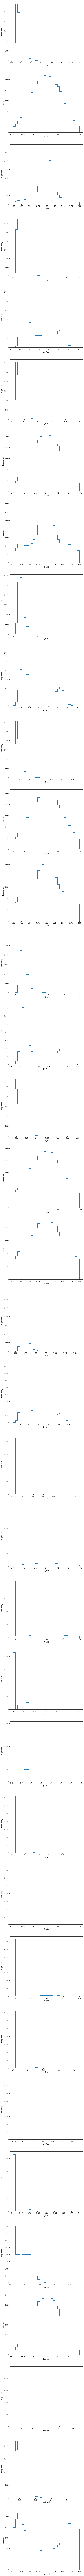

In [17]:
# Histograms of input variables 
show = True

if show:
    plt.figure(figsize=(8,8*input_length))
    for i in range(0, input_length):
        plt.subplot(input_length, 1, i+1)
        plt.hist(train_input[:,i], 30, histtype='step')
        plt.xlabel(input_keys[i])
        plt.ylabel('Frequency')

 

In [18]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-6)
callback = keras.callbacks.EarlyStopping(monitor='val_mse', patience=4)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(input_keys)]),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(256,  activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(len(output_keys),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      input_shape=[len(input_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [19]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               18944     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1

In [20]:
# Fit model

Epochs= 2048

history = model.fit(train_input, train_output, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Epoch 1/2048
149/149 [==============================] - 1s 6ms/step - loss: 0.1637 - mse: 0.1569 - val_loss: 0.1600 - val_mse: 0.1532
Epoch 2/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.1561 - mse: 0.1494 - val_loss: 0.1520 - val_mse: 0.1452
Epoch 3/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.1476 - mse: 0.1409 - val_loss: 0.1430 - val_mse: 0.1362
Epoch 4/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.1383 - mse: 0.1316 - val_loss: 0.1334 - val_mse: 0.1266
Epoch 5/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.1285 - mse: 0.1217 - val_loss: 0.1232 - val_mse: 0.1165
Epoch 6/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.1181 - mse: 0.1114 - val_loss: 0.1126 - val_mse: 0.1059
Epoch 7/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.1072 - mse: 0.1006 - val_loss: 0.1016 - val_mse: 0.0949
Epoch 8/2048
149/149 [==============================] - 1s 5ms

Epoch 62/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0304 - mse: 0.0244 - val_loss: 0.0304 - val_mse: 0.0244
Epoch 63/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0302 - mse: 0.0242 - val_loss: 0.0302 - val_mse: 0.0242
Epoch 64/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0300 - mse: 0.0240 - val_loss: 0.0300 - val_mse: 0.0240
Epoch 65/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0298 - mse: 0.0239 - val_loss: 0.0298 - val_mse: 0.0238
Epoch 66/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0297 - mse: 0.0237 - val_loss: 0.0296 - val_mse: 0.0236
Epoch 67/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0295 - mse: 0.0235 - val_loss: 0.0294 - val_mse: 0.0235
Epoch 68/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0293 - mse: 0.0233 - val_loss: 0.0293 - val_mse: 0.0233
Epoch 69/2048
149/149 [==============================] 

149/149 [==============================] - 1s 5ms/step - loss: 0.0251 - mse: 0.0197 - val_loss: 0.0252 - val_mse: 0.0199
Epoch 123/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0250 - mse: 0.0197 - val_loss: 0.0252 - val_mse: 0.0198
Epoch 124/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0250 - mse: 0.0196 - val_loss: 0.0252 - val_mse: 0.0198
Epoch 125/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0250 - mse: 0.0196 - val_loss: 0.0251 - val_mse: 0.0198
Epoch 126/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0249 - mse: 0.0196 - val_loss: 0.0251 - val_mse: 0.0198
Epoch 127/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0249 - mse: 0.0196 - val_loss: 0.0251 - val_mse: 0.0197
Epoch 128/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0249 - mse: 0.0195 - val_loss: 0.0250 - val_mse: 0.0197
Epoch 129/2048
149/149 [==============================] - 1s 5m

149/149 [==============================] - 1s 5ms/step - loss: 0.0235 - mse: 0.0187 - val_loss: 0.0238 - val_mse: 0.0190
Epoch 183/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0235 - mse: 0.0187 - val_loss: 0.0238 - val_mse: 0.0189
Epoch 184/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0235 - mse: 0.0187 - val_loss: 0.0237 - val_mse: 0.0189
Epoch 185/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0235 - mse: 0.0187 - val_loss: 0.0237 - val_mse: 0.0189
Epoch 186/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0234 - mse: 0.0187 - val_loss: 0.0237 - val_mse: 0.0189
Epoch 187/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0234 - mse: 0.0186 - val_loss: 0.0237 - val_mse: 0.0189
Epoch 188/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0234 - mse: 0.0186 - val_loss: 0.0237 - val_mse: 0.0189
Epoch 189/2048
149/149 [==============================] - 1s 5m

149/149 [==============================] - 1s 5ms/step - loss: 0.0226 - mse: 0.0182 - val_loss: 0.0229 - val_mse: 0.0185
Epoch 243/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0225 - mse: 0.0182 - val_loss: 0.0229 - val_mse: 0.0185
Epoch 244/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0225 - mse: 0.0182 - val_loss: 0.0228 - val_mse: 0.0185
Epoch 245/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0225 - mse: 0.0182 - val_loss: 0.0228 - val_mse: 0.0185
Epoch 246/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0225 - mse: 0.0182 - val_loss: 0.0228 - val_mse: 0.0185
Epoch 247/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0225 - mse: 0.0181 - val_loss: 0.0228 - val_mse: 0.0185
Epoch 248/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0225 - mse: 0.0181 - val_loss: 0.0228 - val_mse: 0.0185
Epoch 249/2048
149/149 [==============================] - 1s 5m

149/149 [==============================] - 1s 5ms/step - loss: 0.0218 - mse: 0.0178 - val_loss: 0.0222 - val_mse: 0.0182
Epoch 303/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0218 - mse: 0.0178 - val_loss: 0.0222 - val_mse: 0.0182
Epoch 304/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0218 - mse: 0.0178 - val_loss: 0.0222 - val_mse: 0.0182
Epoch 305/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0218 - mse: 0.0178 - val_loss: 0.0222 - val_mse: 0.0182
Epoch 306/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0218 - mse: 0.0178 - val_loss: 0.0222 - val_mse: 0.0182
Epoch 307/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0218 - mse: 0.0178 - val_loss: 0.0222 - val_mse: 0.0182
Epoch 308/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0218 - mse: 0.0178 - val_loss: 0.0221 - val_mse: 0.0182
Epoch 309/2048
149/149 [==============================] - 1s 5m

149/149 [==============================] - 1s 5ms/step - loss: 0.0213 - mse: 0.0176 - val_loss: 0.0217 - val_mse: 0.0180
Epoch 363/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0213 - mse: 0.0176 - val_loss: 0.0217 - val_mse: 0.0180
Epoch 364/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0213 - mse: 0.0175 - val_loss: 0.0217 - val_mse: 0.0180
Epoch 365/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0212 - mse: 0.0175 - val_loss: 0.0217 - val_mse: 0.0180
Epoch 366/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0212 - mse: 0.0175 - val_loss: 0.0216 - val_mse: 0.0180
Epoch 367/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0212 - mse: 0.0175 - val_loss: 0.0216 - val_mse: 0.0180
Epoch 368/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0212 - mse: 0.0175 - val_loss: 0.0216 - val_mse: 0.0179
Epoch 369/2048
149/149 [==============================] - 1s 5m

Epoch 422/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0208 - mse: 0.0173 - val_loss: 0.0213 - val_mse: 0.0178
Epoch 423/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0208 - mse: 0.0173 - val_loss: 0.0213 - val_mse: 0.0178
Epoch 424/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0208 - mse: 0.0173 - val_loss: 0.0213 - val_mse: 0.0178
Epoch 425/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0208 - mse: 0.0173 - val_loss: 0.0212 - val_mse: 0.0178
Epoch 426/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0208 - mse: 0.0173 - val_loss: 0.0212 - val_mse: 0.0178
Epoch 427/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0208 - mse: 0.0173 - val_loss: 0.0212 - val_mse: 0.0178
Epoch 428/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0208 - mse: 0.0173 - val_loss: 0.0212 - val_mse: 0.0178
Epoch 429/2048
149/149 [========================

149/149 [==============================] - 1s 5ms/step - loss: 0.0204 - mse: 0.0172 - val_loss: 0.0209 - val_mse: 0.0177
Epoch 483/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0204 - mse: 0.0172 - val_loss: 0.0209 - val_mse: 0.0177
Epoch 484/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0204 - mse: 0.0172 - val_loss: 0.0209 - val_mse: 0.0177
Epoch 485/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0204 - mse: 0.0171 - val_loss: 0.0209 - val_mse: 0.0177
Epoch 486/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0204 - mse: 0.0171 - val_loss: 0.0209 - val_mse: 0.0177
Epoch 487/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0204 - mse: 0.0171 - val_loss: 0.0209 - val_mse: 0.0176
Epoch 488/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0204 - mse: 0.0171 - val_loss: 0.0209 - val_mse: 0.0176
Epoch 489/2048
149/149 [==============================] - 1s 5m

149/149 [==============================] - 1s 5ms/step - loss: 0.0201 - mse: 0.0170 - val_loss: 0.0207 - val_mse: 0.0175
Epoch 543/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0201 - mse: 0.0170 - val_loss: 0.0207 - val_mse: 0.0175
Epoch 544/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0201 - mse: 0.0170 - val_loss: 0.0206 - val_mse: 0.0175
Epoch 545/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0201 - mse: 0.0170 - val_loss: 0.0206 - val_mse: 0.0175
Epoch 546/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0201 - mse: 0.0170 - val_loss: 0.0206 - val_mse: 0.0175
Epoch 547/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0201 - mse: 0.0170 - val_loss: 0.0206 - val_mse: 0.0175
Epoch 548/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0201 - mse: 0.0170 - val_loss: 0.0206 - val_mse: 0.0175
Epoch 549/2048
149/149 [==============================] - 1s 5m

149/149 [==============================] - 1s 5ms/step - loss: 0.0198 - mse: 0.0168 - val_loss: 0.0204 - val_mse: 0.0174
Epoch 603/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0198 - mse: 0.0168 - val_loss: 0.0204 - val_mse: 0.0174
Epoch 604/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0198 - mse: 0.0168 - val_loss: 0.0204 - val_mse: 0.0174
Epoch 605/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0198 - mse: 0.0168 - val_loss: 0.0204 - val_mse: 0.0174
Epoch 606/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0198 - mse: 0.0168 - val_loss: 0.0204 - val_mse: 0.0174
Epoch 607/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0198 - mse: 0.0168 - val_loss: 0.0204 - val_mse: 0.0174
Epoch 608/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0198 - mse: 0.0168 - val_loss: 0.0204 - val_mse: 0.0174
Epoch 609/2048
149/149 [==============================] - 1s 5m

149/149 [==============================] - 1s 5ms/step - loss: 0.0196 - mse: 0.0167 - val_loss: 0.0202 - val_mse: 0.0174
Epoch 663/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0196 - mse: 0.0167 - val_loss: 0.0202 - val_mse: 0.0174
Epoch 664/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0196 - mse: 0.0167 - val_loss: 0.0202 - val_mse: 0.0174
Epoch 665/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0196 - mse: 0.0167 - val_loss: 0.0202 - val_mse: 0.0173
Epoch 666/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0196 - mse: 0.0167 - val_loss: 0.0202 - val_mse: 0.0173
Epoch 667/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0196 - mse: 0.0167 - val_loss: 0.0202 - val_mse: 0.0173
Epoch 668/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0196 - mse: 0.0167 - val_loss: 0.0202 - val_mse: 0.0173
Epoch 669/2048
149/149 [==============================] - 1s 5m

149/149 [==============================] - 1s 5ms/step - loss: 0.0194 - mse: 0.0166 - val_loss: 0.0200 - val_mse: 0.0173
Epoch 723/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0194 - mse: 0.0166 - val_loss: 0.0200 - val_mse: 0.0173
Epoch 724/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0194 - mse: 0.0166 - val_loss: 0.0200 - val_mse: 0.0173
Epoch 725/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0194 - mse: 0.0166 - val_loss: 0.0200 - val_mse: 0.0173
Epoch 726/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0193 - mse: 0.0166 - val_loss: 0.0200 - val_mse: 0.0173
Epoch 727/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0193 - mse: 0.0166 - val_loss: 0.0200 - val_mse: 0.0173
Epoch 728/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0193 - mse: 0.0166 - val_loss: 0.0200 - val_mse: 0.0173
Epoch 729/2048
149/149 [==============================] - 1s 5m

149/149 [==============================] - 1s 5ms/step - loss: 0.0192 - mse: 0.0165 - val_loss: 0.0199 - val_mse: 0.0172
Epoch 783/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0192 - mse: 0.0165 - val_loss: 0.0199 - val_mse: 0.0172
Epoch 784/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0192 - mse: 0.0165 - val_loss: 0.0199 - val_mse: 0.0172
Epoch 785/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0192 - mse: 0.0165 - val_loss: 0.0199 - val_mse: 0.0172
Epoch 786/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0192 - mse: 0.0165 - val_loss: 0.0199 - val_mse: 0.0172
Epoch 787/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0192 - mse: 0.0165 - val_loss: 0.0199 - val_mse: 0.0172
Epoch 788/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0191 - mse: 0.0165 - val_loss: 0.0199 - val_mse: 0.0172
Epoch 789/2048
149/149 [==============================] - 1s 5m

149/149 [==============================] - 1s 5ms/step - loss: 0.0190 - mse: 0.0164 - val_loss: 0.0197 - val_mse: 0.0172
Epoch 843/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0190 - mse: 0.0164 - val_loss: 0.0197 - val_mse: 0.0172
Epoch 844/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0190 - mse: 0.0164 - val_loss: 0.0197 - val_mse: 0.0171
Epoch 845/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0190 - mse: 0.0164 - val_loss: 0.0197 - val_mse: 0.0171
Epoch 846/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0190 - mse: 0.0164 - val_loss: 0.0197 - val_mse: 0.0171
Epoch 847/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0190 - mse: 0.0164 - val_loss: 0.0197 - val_mse: 0.0171
Epoch 848/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0190 - mse: 0.0164 - val_loss: 0.0197 - val_mse: 0.0171
Epoch 849/2048
149/149 [==============================] - 1s 5m

149/149 [==============================] - 1s 5ms/step - loss: 0.0188 - mse: 0.0163 - val_loss: 0.0196 - val_mse: 0.0171
Epoch 903/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0188 - mse: 0.0163 - val_loss: 0.0196 - val_mse: 0.0171
Epoch 904/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0188 - mse: 0.0163 - val_loss: 0.0196 - val_mse: 0.0171
Epoch 905/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0188 - mse: 0.0163 - val_loss: 0.0196 - val_mse: 0.0171
Epoch 906/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0188 - mse: 0.0163 - val_loss: 0.0196 - val_mse: 0.0171
Epoch 907/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0188 - mse: 0.0163 - val_loss: 0.0196 - val_mse: 0.0171
Epoch 908/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0188 - mse: 0.0163 - val_loss: 0.0196 - val_mse: 0.0171
Epoch 909/2048
149/149 [==============================] - 1s 5m

149/149 [==============================] - 1s 5ms/step - loss: 0.0187 - mse: 0.0162 - val_loss: 0.0195 - val_mse: 0.0171
Epoch 963/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0187 - mse: 0.0162 - val_loss: 0.0195 - val_mse: 0.0171
Epoch 964/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0187 - mse: 0.0162 - val_loss: 0.0195 - val_mse: 0.0171
Epoch 965/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0187 - mse: 0.0162 - val_loss: 0.0195 - val_mse: 0.0171
Epoch 966/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0187 - mse: 0.0162 - val_loss: 0.0195 - val_mse: 0.0171
Epoch 967/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0187 - mse: 0.0162 - val_loss: 0.0195 - val_mse: 0.0171
Epoch 968/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0187 - mse: 0.0162 - val_loss: 0.0195 - val_mse: 0.0171
Epoch 969/2048
149/149 [==============================] - 1s 5m

149/149 [==============================] - 1s 5ms/step - loss: 0.0185 - mse: 0.0161 - val_loss: 0.0194 - val_mse: 0.0170
Epoch 1023/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0185 - mse: 0.0161 - val_loss: 0.0194 - val_mse: 0.0170
Epoch 1024/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0185 - mse: 0.0161 - val_loss: 0.0194 - val_mse: 0.0170
Epoch 1025/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0185 - mse: 0.0161 - val_loss: 0.0194 - val_mse: 0.0170
Epoch 1026/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0185 - mse: 0.0161 - val_loss: 0.0194 - val_mse: 0.0170
Epoch 1027/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0185 - mse: 0.0161 - val_loss: 0.0194 - val_mse: 0.0170
Epoch 1028/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0185 - mse: 0.0161 - val_loss: 0.0194 - val_mse: 0.0170
Epoch 1029/2048
149/149 [==============================] 

Epoch 1082/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0184 - mse: 0.0160 - val_loss: 0.0193 - val_mse: 0.0170
Epoch 1083/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0184 - mse: 0.0160 - val_loss: 0.0193 - val_mse: 0.0170
Epoch 1084/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0184 - mse: 0.0160 - val_loss: 0.0193 - val_mse: 0.0170
Epoch 1085/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0184 - mse: 0.0160 - val_loss: 0.0193 - val_mse: 0.0170
Epoch 1086/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0184 - mse: 0.0160 - val_loss: 0.0193 - val_mse: 0.0170
Epoch 1087/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0184 - mse: 0.0160 - val_loss: 0.0193 - val_mse: 0.0170
Epoch 1088/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0184 - mse: 0.0160 - val_loss: 0.0193 - val_mse: 0.0170
Epoch 1089/2048
149/149 [================

Epoch 1142/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0183 - mse: 0.0160 - val_loss: 0.0192 - val_mse: 0.0170
Epoch 1143/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0183 - mse: 0.0160 - val_loss: 0.0192 - val_mse: 0.0170
Epoch 1144/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0183 - mse: 0.0160 - val_loss: 0.0192 - val_mse: 0.0170
Epoch 1145/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0183 - mse: 0.0160 - val_loss: 0.0192 - val_mse: 0.0170
Epoch 1146/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0183 - mse: 0.0160 - val_loss: 0.0192 - val_mse: 0.0169
Epoch 1147/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0183 - mse: 0.0160 - val_loss: 0.0192 - val_mse: 0.0169
Epoch 1148/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0183 - mse: 0.0160 - val_loss: 0.0192 - val_mse: 0.0169
Epoch 1149/2048
149/149 [================

Epoch 1202/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0182 - mse: 0.0159 - val_loss: 0.0192 - val_mse: 0.0169
Epoch 1203/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0181 - mse: 0.0159 - val_loss: 0.0192 - val_mse: 0.0169
Epoch 1204/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0181 - mse: 0.0159 - val_loss: 0.0192 - val_mse: 0.0169
Epoch 1205/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0181 - mse: 0.0159 - val_loss: 0.0192 - val_mse: 0.0169
Epoch 1206/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0181 - mse: 0.0159 - val_loss: 0.0192 - val_mse: 0.0169
Epoch 1207/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0181 - mse: 0.0159 - val_loss: 0.0192 - val_mse: 0.0169
Epoch 1208/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0181 - mse: 0.0159 - val_loss: 0.0192 - val_mse: 0.0169
Epoch 1209/2048
149/149 [================

Epoch 1262/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0180 - mse: 0.0158 - val_loss: 0.0191 - val_mse: 0.0169
Epoch 1263/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0180 - mse: 0.0158 - val_loss: 0.0191 - val_mse: 0.0169
Epoch 1264/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0180 - mse: 0.0158 - val_loss: 0.0191 - val_mse: 0.0169
Epoch 1265/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0180 - mse: 0.0158 - val_loss: 0.0191 - val_mse: 0.0169
Epoch 1266/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0180 - mse: 0.0158 - val_loss: 0.0191 - val_mse: 0.0169
Epoch 1267/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0180 - mse: 0.0158 - val_loss: 0.0191 - val_mse: 0.0169
Epoch 1268/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0180 - mse: 0.0158 - val_loss: 0.0191 - val_mse: 0.0169
Epoch 1269/2048
149/149 [================

Epoch 1322/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0179 - mse: 0.0158 - val_loss: 0.0191 - val_mse: 0.0169
Epoch 1323/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0179 - mse: 0.0158 - val_loss: 0.0191 - val_mse: 0.0169
Epoch 1324/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0179 - mse: 0.0158 - val_loss: 0.0191 - val_mse: 0.0169
Epoch 1325/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0179 - mse: 0.0158 - val_loss: 0.0191 - val_mse: 0.0169
Epoch 1326/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0179 - mse: 0.0157 - val_loss: 0.0191 - val_mse: 0.0169
Epoch 1327/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0179 - mse: 0.0157 - val_loss: 0.0191 - val_mse: 0.0169
Epoch 1328/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0179 - mse: 0.0157 - val_loss: 0.0191 - val_mse: 0.0169
Epoch 1329/2048
149/149 [================

Epoch 1382/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0178 - mse: 0.0157 - val_loss: 0.0190 - val_mse: 0.0169
Epoch 1383/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0178 - mse: 0.0157 - val_loss: 0.0190 - val_mse: 0.0169
Epoch 1384/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0178 - mse: 0.0157 - val_loss: 0.0190 - val_mse: 0.0169
Epoch 1385/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0178 - mse: 0.0157 - val_loss: 0.0190 - val_mse: 0.0169
Epoch 1386/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0178 - mse: 0.0157 - val_loss: 0.0190 - val_mse: 0.0169
Epoch 1387/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0178 - mse: 0.0157 - val_loss: 0.0190 - val_mse: 0.0169
Epoch 1388/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0178 - mse: 0.0157 - val_loss: 0.0190 - val_mse: 0.0169
Epoch 1389/2048
149/149 [================

Epoch 1442/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0177 - mse: 0.0156 - val_loss: 0.0190 - val_mse: 0.0169
Epoch 1443/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0177 - mse: 0.0156 - val_loss: 0.0190 - val_mse: 0.0169
Epoch 1444/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0177 - mse: 0.0156 - val_loss: 0.0190 - val_mse: 0.0169
Epoch 1445/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0177 - mse: 0.0156 - val_loss: 0.0190 - val_mse: 0.0169
Epoch 1446/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0177 - mse: 0.0156 - val_loss: 0.0190 - val_mse: 0.0169
Epoch 1447/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0177 - mse: 0.0156 - val_loss: 0.0190 - val_mse: 0.0169
Epoch 1448/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0177 - mse: 0.0156 - val_loss: 0.0190 - val_mse: 0.0169
Epoch 1449/2048
149/149 [================

Epoch 1502/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0176 - mse: 0.0156 - val_loss: 0.0189 - val_mse: 0.0168
Epoch 1503/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0176 - mse: 0.0156 - val_loss: 0.0189 - val_mse: 0.0168
Epoch 1504/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0176 - mse: 0.0156 - val_loss: 0.0189 - val_mse: 0.0168
Epoch 1505/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0176 - mse: 0.0156 - val_loss: 0.0189 - val_mse: 0.0168
Epoch 1506/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0176 - mse: 0.0155 - val_loss: 0.0189 - val_mse: 0.0168
Epoch 1507/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0176 - mse: 0.0155 - val_loss: 0.0189 - val_mse: 0.0168
Epoch 1508/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0176 - mse: 0.0155 - val_loss: 0.0189 - val_mse: 0.0168
Epoch 1509/2048
149/149 [================

Epoch 1562/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0175 - mse: 0.0155 - val_loss: 0.0189 - val_mse: 0.0168
Epoch 1563/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0175 - mse: 0.0155 - val_loss: 0.0189 - val_mse: 0.0168
Epoch 1564/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0175 - mse: 0.0155 - val_loss: 0.0189 - val_mse: 0.0168
Epoch 1565/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0175 - mse: 0.0155 - val_loss: 0.0189 - val_mse: 0.0168
Epoch 1566/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0175 - mse: 0.0155 - val_loss: 0.0189 - val_mse: 0.0168
Epoch 1567/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0175 - mse: 0.0155 - val_loss: 0.0189 - val_mse: 0.0168
Epoch 1568/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0175 - mse: 0.0155 - val_loss: 0.0189 - val_mse: 0.0168
Epoch 1569/2048
149/149 [================

Epoch 1622/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0174 - mse: 0.0154 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1623/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0174 - mse: 0.0154 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1624/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0174 - mse: 0.0154 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1625/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0174 - mse: 0.0154 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1626/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0174 - mse: 0.0154 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1627/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0174 - mse: 0.0154 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1628/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0174 - mse: 0.0154 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1629/2048
149/149 [================

Epoch 1682/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0174 - mse: 0.0154 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1683/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0174 - mse: 0.0154 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1684/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0174 - mse: 0.0154 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1685/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0174 - mse: 0.0154 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1686/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0173 - mse: 0.0154 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1687/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0173 - mse: 0.0154 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1688/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0173 - mse: 0.0154 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1689/2048
149/149 [================

Epoch 1742/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0173 - mse: 0.0153 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1743/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0173 - mse: 0.0153 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1744/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0173 - mse: 0.0153 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1745/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0173 - mse: 0.0153 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1746/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0173 - mse: 0.0153 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1747/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0173 - mse: 0.0153 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1748/2048
149/149 [==============================] - 1s 5ms/step - loss: 0.0173 - mse: 0.0153 - val_loss: 0.0188 - val_mse: 0.0168
Epoch 1749/2048
149/149 [================

In [21]:
history.history.keys()
model.save(model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: Weight_lep_pt/assets


Text(0.5, 1.0, 'MSE loss')

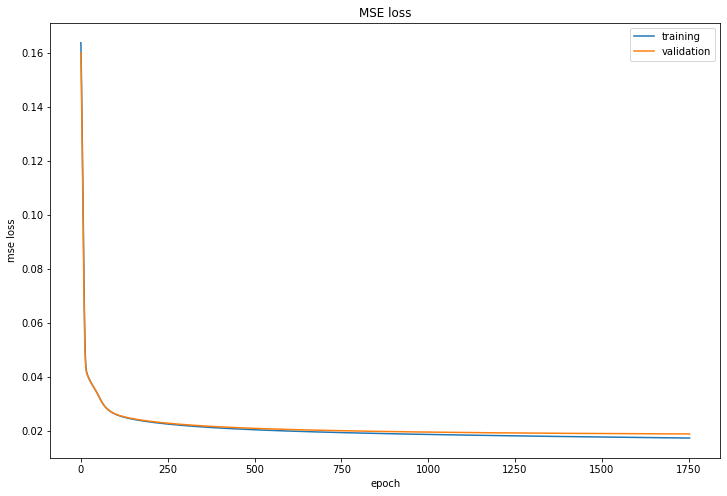

In [22]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [23]:
predictions = model.predict(test_input)

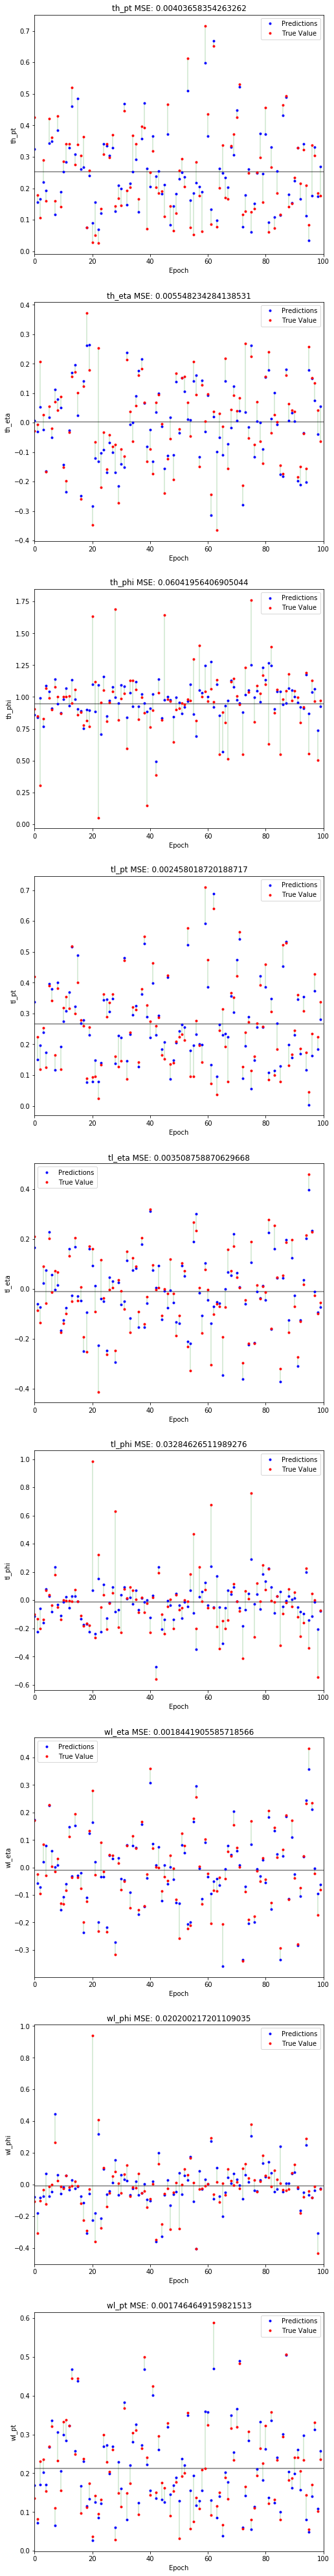

In [24]:

# Training 
crop = 100 

train_small = model.predict(train_input[0:100,:])
output_small = train_output[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0,output_length):
        plt.subplot(output_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(output_keys[i])
        plt.xlim(0, crop)
        plt.title(output_keys[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, output_small)

In [25]:
# Predictions

predictions_small = predictions[0:100,:]
test_output_small = test_output[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- test_output)**2)
print("total MSE: " + str(MSE))

for i in range(output_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -test_output[:,i])**2)
    print("{0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

total MSE: 0.028020979695152933
th_pt MSE :  0.0040235809
th_eta MSE :  0.0100891271
th_phi MSE :  0.1175994957
tl_pt MSE :  0.0032177078
tl_eta MSE :  0.0075320436
tl_phi MSE :  0.0782593452
wl_eta MSE :  0.0045869634
wl_phi MSE :  0.0253202801
wl_pt MSE :  0.0015602732


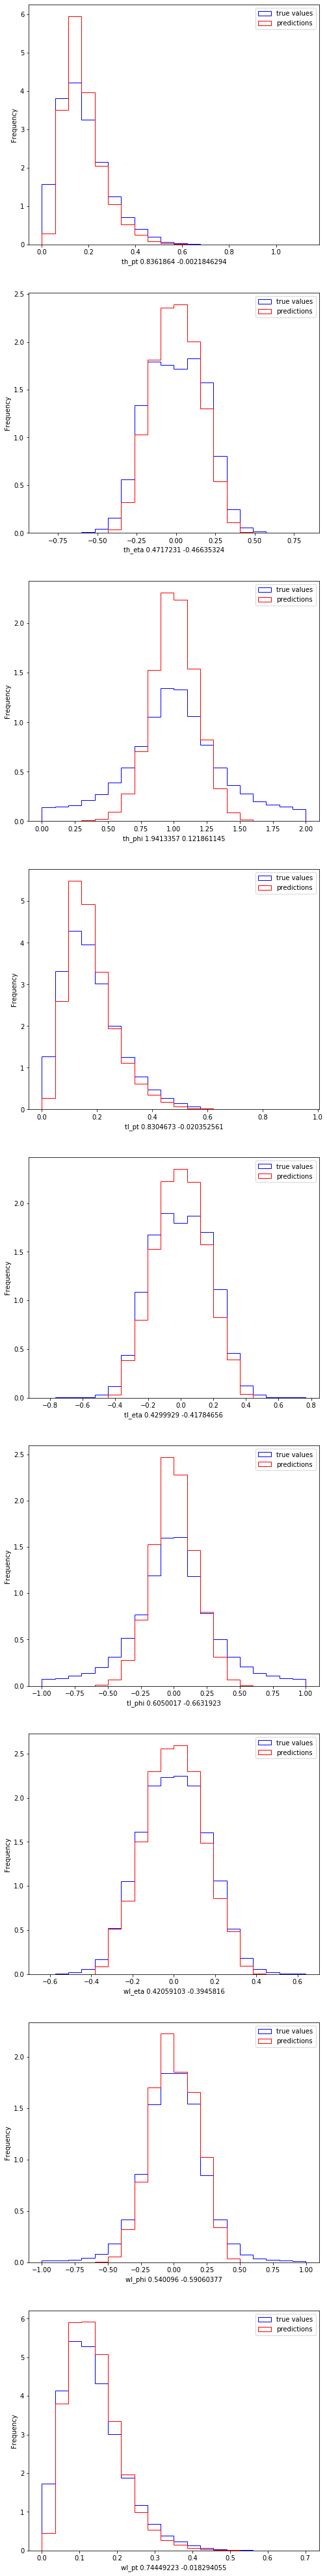

In [26]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    hist0, bin_edges = np.histogram(test_output[:, i], bins=20)
    plt.hist(test_output[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

In [27]:
total_output = scale_arrays(output_keys, maxmean)
out_scaled = invscale_arrays(output_keys, total_output, maxmean)[split:,:]

total_predictions = model.predict(total_input)
predict_scaled = invscale_arrays(output_keys, total_predictions, maxmean)[split:,:]


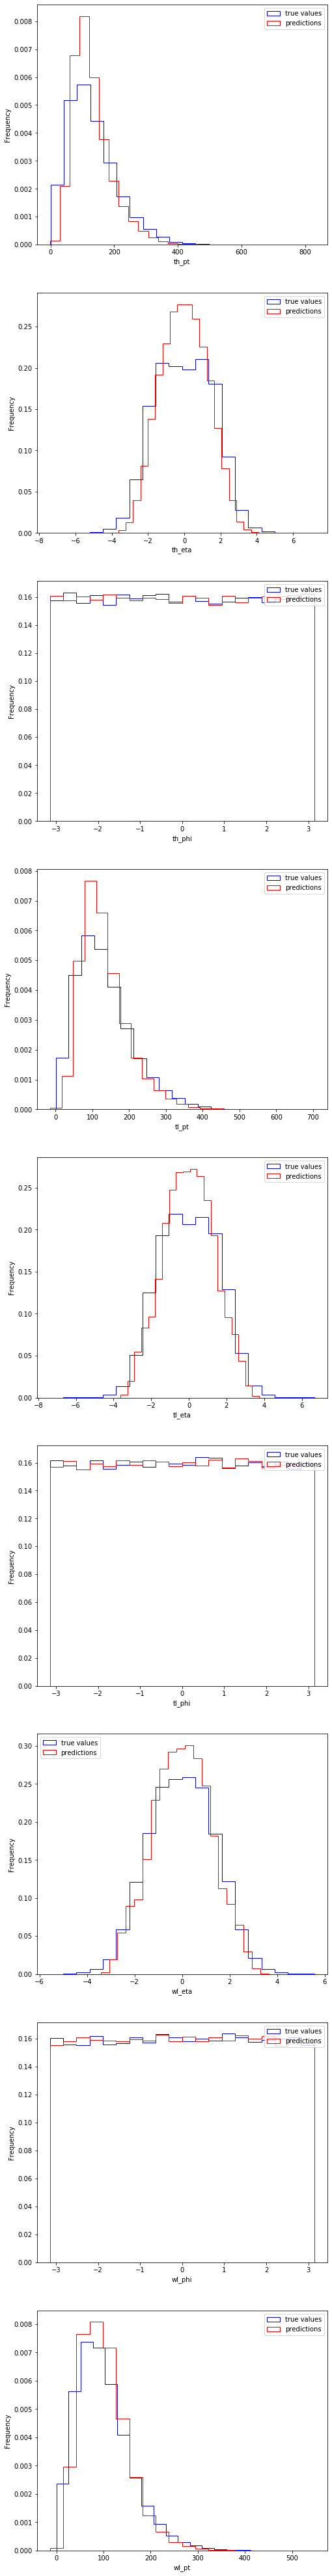

In [28]:
# Histograms to the original scale 

# out_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_output)
# out_scaled = invscale_arrays(output_keys, test_output, maxmean)
# predict_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_predictions)[split:,:]


plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.hist(out_scaled[:, i], 20, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], 20, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [29]:
for i in range(output_length):
    if output_keys[i].split("_")[1] == 'phi':
        mod_pi = (predict_scaled[:,i] - out_scaled[:,i]) % (2*np.pi)
        mod_pi = mod_pi - 2*np.pi*(mod_pi > np.pi)
        MSE = 1/predict_scaled[:,i].size*np.sum((mod_pi)**2)
    else:
        MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] - out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  2173.6310698419
Original Scale th_eta MSE :  0.7618264116
Original Scale th_phi MSE :  1.0867792727
Original Scale tl_pt MSE :  1738.2798631841
Original Scale tl_eta MSE :  0.5687419419
Original Scale tl_phi MSE :  0.7237879262
Original Scale wl_eta MSE :  0.3463599816
Original Scale wl_phi MSE :  0.2371139568
Original Scale wl_pt MSE :  842.8955325489


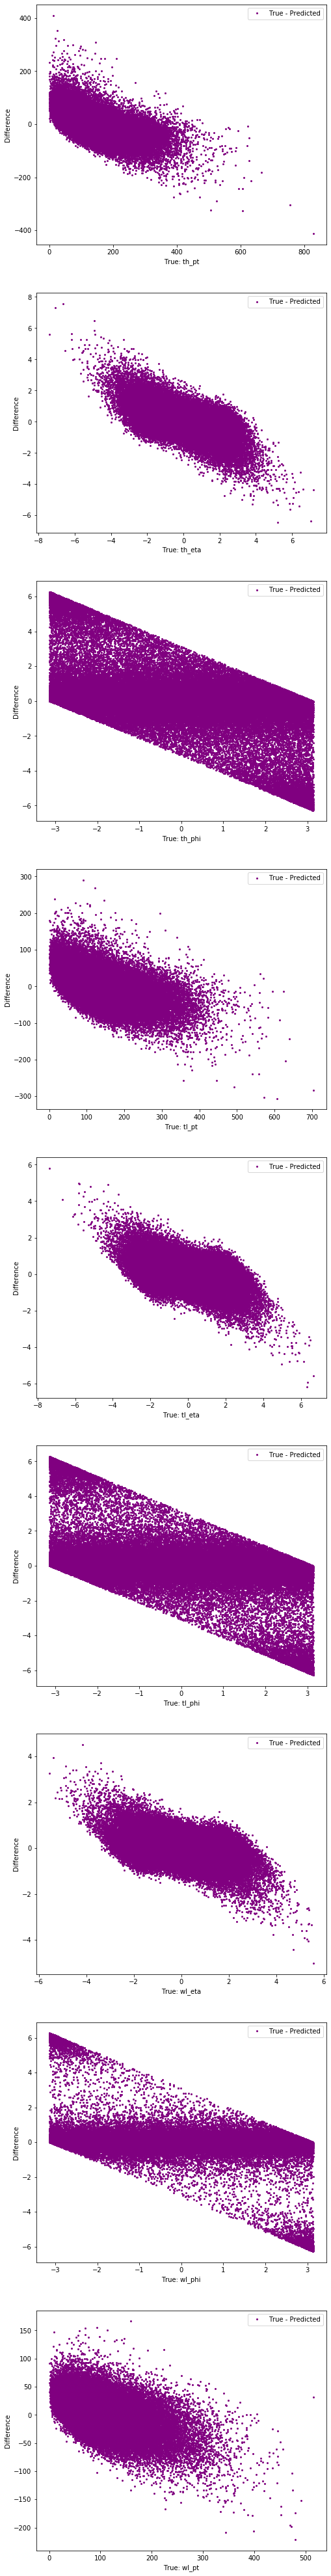

In [30]:
plt.figure(figsize=(8,8*output_length))
for i in range(output_length):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.plot(out_scaled[:, i], predict_scaled[:, i]-out_scaled[:, i], 'o', color='purple', label='True - Predicted', markersize=2)
    plt.xlabel('True: ' + output_keys[i])
    plt.legend()
    plt.ylabel('Difference')